In [ ]:
# create requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import random
from urllib import request
import shutil
import gzip
import os

# Prepare the Dataset

### Download and unzip the MNIST dataset

In [8]:
base_url = 'http://yann.lecun.com/exdb/mnist/'

dataset = ['train-images.idx3-ubyte', 'train-labels.idx1-ubyte',
           't10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte']

for file in dataset:
    
    _file = file.replace('.', '-') + '.gz'
    
    if _file not in os.listdir():
        with request.urlopen(f'{base_url}{_file}') as response, open(_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
    
    if file not in os.listdir():
        with gzip.open(_file, 'rb') as f_in, open(file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

### Load the dataset

In [9]:
train_images = idx2numpy.convert_from_file(dataset[0]) / 255.0
train_labels = idx2numpy.convert_from_file(dataset[1])
test_images = idx2numpy.convert_from_file(dataset[2]) / 255.0
test_labels = idx2numpy.convert_from_file(dataset[3])

### Plot a random sample

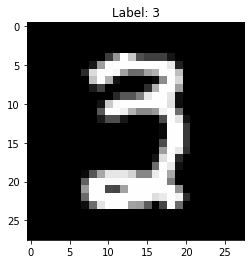

In [10]:
idx = random.randint(0, len(train_images))
plt.title(f'Label: {train_labels[idx]}')
plt.imshow(train_images[idx], cmap='gray')

In [11]:
def relu(vector):
    vector[vector<0] = 0
    return vector

In [32]:
def relu_derivative(vector):
    vector[vector<=0] = 0
    vector[vector>0] = 1
    return vector

In [12]:
def softmax(vector):
    exp = np.exp(vector)# - np.max(vector))
    return exp / exp.sum()

In [13]:
def cross_entropy(predict, label):
    return -np.sum(label*np.log(predict))

In [17]:
def cross_entropy_derivative(predict, label):
    return -label/predict

In [18]:
def softmax_derivative(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

In [19]:
# Fixed softmax derivative which returns the jacobian instead
# see https://stackoverflow.com/questions/33541930/how-to-implement-the-softmax-derivative-independently-from-any-loss-function 

v = np.array([-1.0, -1.0, 1.0]) # unscaled logits
t = np.array([0.0,1.0,0.0])     # target probability distribution

soft = softmax(v)           # [0.10650698, 0.10650698, 0.78698604]
print('soft', soft)
taa = cross_entropy(soft, t)       # 2.2395447662218846
print('loss', taa)

cross_der = cross_entropy_derivative(soft, t)
print(cross_der)
                            # [-0.       , -9.3890561, -0.       ]

soft_der = softmax_derivative(soft)
print(soft_der)

#[[ 0.09516324, -0.01134374, -0.08381951],
#[-0.01134374,  0.09516324, -0.08381951],
#[-0.08381951, -0.08381951,  0.16763901]]


# derivative using chain rule 
print(cross_der  @ soft_der)      # [[ 0.10650698, -0.89349302,  0.78698604]]
print(np.dot(cross_der, soft_der))



# # Derivative using analytical derivation 
print(soft - t)                    # [ 0.10650698, -0.89349302,  0.78698604]

soft [0.10650698 0.10650698 0.78698604]
loss 2.2395447662218846
[-0.        -9.3890561 -0.       ]
[[ 0.09516324 -0.01134374 -0.08381951]
 [-0.01134374  0.09516324 -0.08381951]
 [-0.08381951 -0.08381951  0.16763901]]
[ 0.10650698 -0.89349302  0.78698604]
[ 0.10650698 -0.89349302  0.78698604]
[ 0.10650698 -0.89349302  0.78698604]


In [7]:
# image -> flatten -> layer1 -> inter1 -> acti1 -> layer2 -> inter2 -> acti2 -> loss
#           1x784    784x128    1x128     1x128    128x10    1x10       1x10     1

In [59]:
class CustomMnist:
    
    def __init__(self, input_shape=(28, 28)):
        input_shape = input_shape[0]*input_shape[1]
        self.layer1 = np.random.uniform(-1.0, 1.0, size=(input_shape, 128))/np.sqrt(input_shape*128)
        self.layer2 = np.random.uniform(-1.0, 1.0, size=(128, 10))/np.sqrt(128*10)
        
        self.layer1 = self.layer1.astype(np.float32)
        self.layer2 = self.layer2.astype(np.float32)
        
    def forward(self, image):
        
        self.flatten = np.reshape(image, (1, image.shape[0]*image.shape[1]))
        self.inter1 = np.dot(self.flatten, self.layer1)
        self.acti1 = relu(self.inter1)
        self.inter2 = np.dot(self.acti1, self.layer2)        
        self.acti2 = softmax(self.inter2)
        
        return self.acti2
    
    def back_propagation(self, image, label):
        
        label_arr = np.zeros((1, 10))
        label_arr[0][label] = 1
        
        loss = cross_entropy(self.acti2, label_arr)
        
        d_cross_entropy = cross_entropy_derivative(self.acti2, label_arr)
#         d_softmax = softmax_derivative(self.acti2)
        d_so = d_cross_entropy.dot(softmax_derivative(self.inter2))
        
        print(d_so.shape)
        
#         delta2 = np.dot(d_cross_entropy, d_softmax)
#         print(delta2.shape)
        
#         d_layer2 = np.dot(self.acti1.T, delta2)
#         print(d_layer2.shape)
        
#         print(relu_derivative(self.acti1).shape)
        
#         a = np.dot()
        
#         d_relu = np.dot(relu_derivative(self.acti1), )
        
#         delta1 = np.dot(d_relu, )
        
        
        
#         print(d_relu.shape)
#         print(self.acti2 - label_arr)
        
        
    def view(self):
        
        print('\nLayers\n----------------------------')
        print('Layer1: \t', self.layer1.shape)
        print('Layer2: \t', self.layer2.shape, end='\n\n')
        print('Flatten: \t', self.flatten.shape)
        print('Inter1: \t', self.inter1.shape)
        print('Acti1:  \t', self.acti1.shape)
        print('Inter2: \t', self.inter2.shape)
        print('Acti2:  \t', self.acti2.shape)
        
                                        
custom_mnist = CustomMnist()

op = custom_mnist.forward(train_images[0])
custom_mnist.back_propagation(train_images[0], train_labels[0])

custom_mnist.view()

(1, 10)

Layers
----------------------------
Layer1: 	 (784, 128)
Layer2: 	 (128, 10)

Flatten: 	 (1, 784)
Inter1: 	 (1, 128)
Acti1:  	 (1, 128)
Inter2: 	 (1, 10)
Acti2:  	 (1, 10)


In [ ]:
28*28